In [2]:
# # Uncomment to install required packages
# ! pip install witwidget
# ! pip install shap

In [3]:
# Boilerplate functions
def plot_fi(model, df): 
  return pd.DataFrame(index = df.columns.to_list(), data = model.feature_importances_, columns = ['importance']).sort_values(by ='importance').plot(kind = 'barh');

# XAI with the SHAP library
SHAP (SHapley Additive exPlanations) is a game theoretic approach adapted to the ML domain, used to explain the output any model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. 
- Learn more about the SHAP library [here](https://shap.readthedocs.io/en/latest/index.html).  
- A cool video to understand the Shapley approach [here](https://www.coursera.org/lecture/negotiation/the-shapley-value-solving-the-runway-problem-3A3er) 

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder
import shap
import joblib

In [6]:
X = pd.read_csv('XAI_DATA/patient_data.csv')
X.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,...,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,70.0,0,0,72.56,30.4
1,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,43.0,0,0,91.13,33.9
2,0,1,0,1,0,0,0,0,0,1,...,1,0,0,1,0,13.0,0,0,122.31,15.3
3,1,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,16.0,0,0,87.16,28.2
4,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,21.0,0,0,71.34,24.0


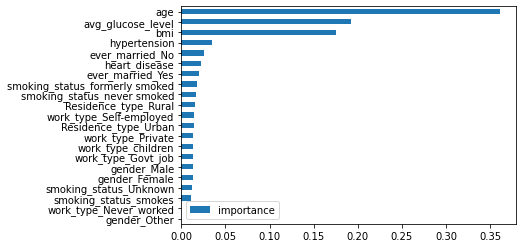

In [8]:
model = joblib.load("./XAI_DATA/random_forest.joblib")
plot_fi(model, X);

In [9]:
# Explore specific patient prediction 
patient_index = 985
patient_data = X.iloc[[patient_index]]
pred = model.predict(patient_data)
print(f'Predicting for patient {patient_index}: {pred}' )

Predicting for patient 985: [1]


In [10]:
# Define an explainer
explainer =shap.Explainer(model)
# get shap values
shap_values = explainer.shap_values(patient_data); shap_values

[array([[-8.57388317e-03,  3.14065282e-03, -9.81692800e-07,
         -1.29634261e-02, -3.35656717e-03, -5.11491602e-03,
         -4.06090383e-05,  4.72943443e-02,  3.51415676e-03,
         -7.28237877e-03, -1.18441174e-02, -1.09784066e-02,
         -2.79064332e-03,  1.59902524e-02, -5.91217977e-04,
          7.34843546e-04, -1.36862197e-01, -1.19516344e-01,
          5.16836526e-04,  8.40843186e-02,  9.40925850e-02]]),
 array([[ 8.57388317e-03, -3.14065282e-03,  9.81692800e-07,
          1.29634261e-02,  3.35656717e-03,  5.11491602e-03,
          4.06090383e-05, -4.72943443e-02, -3.51415676e-03,
          7.28237877e-03,  1.18441174e-02,  1.09784066e-02,
          2.79064332e-03, -1.59902524e-02,  5.91217977e-04,
         -7.34843546e-04,  1.36862197e-01,  1.19516344e-01,
         -5.16836526e-04, -8.40843186e-02, -9.40925850e-02]])]

In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

In [12]:

# We can wrap the process in a function and explore multiple patients
def predict_patient(idx):
    patient = X.loc[[idx]]
    prediction = model.predict(patient)
    print(f'Prediction for patient {idx}: {prediction}')
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    fplot = shap.force_plot(explainer.expected_value[1], shap_values[1], patient, show = True)
    return fplot

In [13]:
patient_idx = 10
predict_patient(patient_idx)

Prediction for patient 10: [0]


In [14]:
#This one was a false negative 
patient_idx = 82
predict_patient(patient_idx)

Prediction for patient 82: [0]


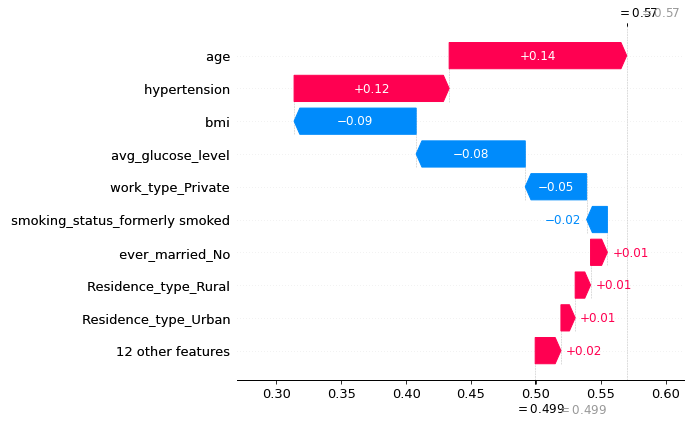

In [15]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1].reshape(-1),  patient_data.values.reshape(-1), feature_names = X.columns.to_list(), show = True)

# XAI with the What If Tool 

In [16]:
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder
num_datapoints = 200  #@param {type: "number"}


# Return model predictions and SHAP values for each inference.
def custom_predict_with_shap(model_inputs):

  # Get the class predictions from the model.
  preds = model.predict_proba(model_inputs)
  # preds = [[1 - pred[0], pred[0]] for pred in preds] if using nnet

  # Get the SHAP values from the explainer and create a map of feature name
  # to SHAP value for each example passed to the model.
  shap_output = explainer.shap_values(np.array(model_inputs))[1]
  attributions = []
  for shap in shap_output:
    attrs = {}
    for i, col in enumerate(X.columns):
      attrs[col] = shap[i]
    attributions.append(attrs)
  ret = {'predictions': preds, 'attributions': attributions}
  return ret

examples_for_shap_wit = X.values.tolist()
column_names = X.columns.tolist() + ['stroke']

config_builder = WitConfigBuilder(
    examples_for_shap_wit[:num_datapoints],
    feature_names=column_names).set_custom_predict_fn(
  custom_predict_with_shap).set_target_feature('stroke').set_label_vocab(['No stroke', 'Stroke'])

ww = WitWidget(config_builder, height=600)

In [21]:
!jupyter labextension install wit-widget
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

An error occured.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-o5i0cof2.log
An error occured.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-7q8hfbjs.log


In [20]:
WitWidget(config_builder, height=600)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['No stroke', 'Stroke'], 'feature_names': ['g…

In [17]:
ww

WitWidget(config={'model_type': 'classification', 'label_vocab': ['No stroke', 'Stroke'], 'feature_names': ['g…